# Implementation of Baseline Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from sklearn.naive_bayes import MultinomialNB


In [2]:
data = pd.read_csv('./data/cleaned-train-tweets.csv', sep="|")
display(data.sample(5))
train, test = train_test_split(data, test_size=0.3, random_state=30255)


,id,keyword,location,text,target,clean_text
7094,7094,violent%20storm,Yuuko-san's shop,Rather violent storm. Possibility of no stream...,1,rather violent storm possibility stream tonight
14303,14303,lava,Philippines,Get excited to watch Disney/Pixar's LAVA an an...,0,get excited watch lava animated short inside l...
4351,4351,hijack,NaN,Swansea Û÷plot hijack transfer move for South...,1,swansea hijack transfer move southampton targe...
13204,13204,flood,USA,Flood Prone Waterways In Westchester County No...,1,flood prone waterway westchester county eligib...
5089,5089,nuclear%20disaster,"Hammersmith, London",@DalaiLama then have the biggest nuclear disas...,1,dalailama biggest nuclear disaster ever happened


## Vectorization

In [3]:
data_text_list = [str(text) for text in data["clean_text"]]
train_text_list = [str(text) for text in train["clean_text"]]
test_text_list = [str(text) for text in test["clean_text"]]

# TF-IDF
tfidf_vec = TfidfVectorizer(ngram_range=(1,3))
tfidf_vec.fit(data_text_list)
train_text_tfidf = tfidf_vec.transform(train_text_list)
test_text_tfidf = tfidf_vec.transform(test_text_list)

# Count Vectorizer
cvec = CountVectorizer(max_features = 500)
# train_text_cvec = cvec.fit_transform(train['clean_text']).toarray()
# test_text_cvec = cvec.transform(test['clean_text']).toarray()
train_text_cvec = cvec.fit_transform(train_text_list)
test_text_cvec = cvec.transform(test_text_list)


## Logistic Regression

### Using TF-IDF

#### Hyperparameter Tuning

In [4]:
def run_grid_search(model, grid, train_vec, test_vec, train, test):
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy', error_score=0)
    grid_search.fit(train_vec, train['target'])
    grid_result = grid_search.fit(test_vec, test['target'])
    return grid_result

def show_grid_search_result(grid_result):
    print("Best: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))


In [5]:
# Reference: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# define models and parameters
model = LogisticRegression(max_iter=10000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers, penalty=penalty, C=c_values)

# define grid search
grid_result = run_grid_search(model, grid, train_text_tfidf, test_text_tfidf, train, test)

# summarize results
show_grid_search_result(grid_result)


Best: 0.834538 using {'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'} 

0.834538 (0.006008) with: {'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.834357 (0.006117) with: {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.833816 (0.005789) with: {'C': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.834177 (0.006750) with: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.834177 (0.006750) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.834177 (0.006750) with: {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.833275 (0.007860) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.833275 (0.007860) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.833275 (0.007860) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.832373 (0.005397) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832373 (0.005397) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832012 (0.005154) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.791054 (

#### Results

In [6]:
def run_and_show_results(model, train_vec, test_vec, train, test):
    model.fit(train_vec, train['target'])
    train_prediction = model.predict(train_vec)
    test_prediction = model.predict(test_vec)
    print('train data result')
    print(classification_report(train['target'], train_prediction))
    print('test data result')
    print(classification_report(test['target'], test_prediction))

    # Visualization using Confusion Matrix
    cm = confusion_matrix(test['target'], test_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


train data result
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7388
           1       0.99      0.98      0.98      5543

    accuracy                           0.99     12931
   macro avg       0.99      0.99      0.99     12931
weighted avg       0.99      0.99      0.99     12931

test data result
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3141
           1       0.95      0.84      0.89      2401

    accuracy                           0.91      5542
   macro avg       0.92      0.90      0.91      5542
weighted avg       0.91      0.91      0.91      5542



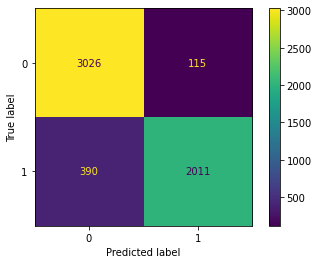

In [7]:
model = LogisticRegression(max_iter=1000, C=1000, penalty='l2', solver='liblinear')
run_and_show_results(model, train_text_tfidf, test_text_tfidf, train, test)


### Using Count Vectorization

#### Hyperparameter Tuning

In [8]:
# define grid search
grid_result = run_grid_search(model, grid, train_text_cvec, test_text_cvec, train, test)

# summarize results
show_grid_search_result(grid_result)


Best: 0.785457 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'} 

0.778961 (0.010993) with: {'C': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.778961 (0.011242) with: {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.778780 (0.010878) with: {'C': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
0.778961 (0.010613) with: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.778600 (0.010345) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.778961 (0.010613) with: {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.780043 (0.011228) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.780043 (0.011228) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.780043 (0.011228) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.783111 (0.010121) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.783111 (0.010121) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.783291 (0.009958) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.785457 (0.

#### Results

train data result
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      7388
           1       0.83      0.73      0.78      5543

    accuracy                           0.82     12931
   macro avg       0.82      0.81      0.81     12931
weighted avg       0.82      0.82      0.82     12931

test data result
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      3141
           1       0.80      0.70      0.75      2401

    accuracy                           0.79      5542
   macro avg       0.80      0.78      0.79      5542
weighted avg       0.79      0.79      0.79      5542



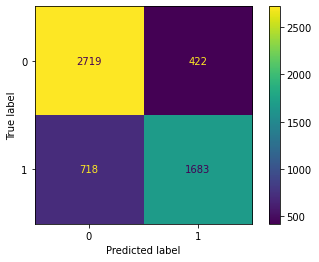

In [9]:
model = LogisticRegression(max_iter=1000, C=1000, penalty='l2', solver='liblinear')
run_and_show_results(model, train_text_cvec, test_text_cvec, train, test)


## Multinomial Naive Bayes Model

### Using TF-IDF

#### Hyperparameter Tuning

In [10]:
# Reference: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# define models and parameters
model = MultinomialNB()
alpha = [100, 10, 1.0, 0.1, 0.01]
grid = dict(alpha=alpha)

# define grid search
grid_result = run_grid_search(model, grid, train_text_tfidf, test_text_tfidf, train, test)

# summarize results
show_grid_search_result(grid_result)


Best: 0.829126 using {'alpha': 1.0} 

0.566763 (0.000287) with: {'alpha': 100}
0.663118 (0.004382) with: {'alpha': 10}
0.829126 (0.008060) with: {'alpha': 1.0}
0.828761 (0.006999) with: {'alpha': 0.1}
0.791049 (0.008692) with: {'alpha': 0.01}


#### Results

train data result
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7388
           1       0.98      0.94      0.96      5543

    accuracy                           0.97     12931
   macro avg       0.97      0.96      0.96     12931
weighted avg       0.97      0.97      0.97     12931

test data result
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3141
           1       0.94      0.80      0.86      2401

    accuracy                           0.89      5542
   macro avg       0.90      0.88      0.88      5542
weighted avg       0.89      0.89      0.89      5542



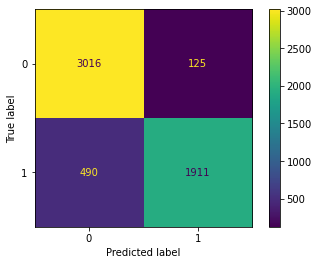

In [11]:
# Reference: https://www.kaggle.com/code/vaishnavibv/disaster-tweet-classification-logistic-regression
model = MultinomialNB(alpha = 1.0)
run_and_show_results(model, train_text_tfidf, test_text_tfidf, train, test)


### Using Count Vectrization

#### Hyperparameter Tuning

In [12]:
# Reference: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# define models and parameters
model = MultinomialNB()
alpha = [100, 10, 1.0, 0.1, 0.01, 0.001]
grid = dict(alpha=alpha)

# define grid search
grid_result = run_grid_search(model, grid, train_text_cvec, test_text_cvec, train, test)

# summarize results
show_grid_search_result(grid_result)


Best: 0.771741 using {'alpha': 1.0} 

0.757671 (0.006473) with: {'alpha': 100}
0.769757 (0.011419) with: {'alpha': 10}
0.771741 (0.013073) with: {'alpha': 1.0}
0.771741 (0.012982) with: {'alpha': 0.1}
0.771560 (0.012359) with: {'alpha': 0.01}
0.771560 (0.012359) with: {'alpha': 0.001}


#### Results

train data result
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      7388
           1       0.78      0.71      0.74      5543

    accuracy                           0.79     12931
   macro avg       0.79      0.78      0.78     12931
weighted avg       0.79      0.79      0.79     12931

test data result
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3141
           1       0.76      0.68      0.72      2401

    accuracy                           0.77      5542
   macro avg       0.77      0.76      0.76      5542
weighted avg       0.77      0.77      0.77      5542



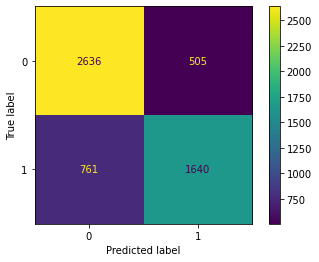

In [13]:
# Reference: https://www.kaggle.com/code/vaishnavibv/disaster-tweet-classification-logistic-regression
model = MultinomialNB(alpha = 0.1)
run_and_show_results(model, train_text_cvec, test_text_cvec, train, test)


## Analysis of misclassifications

The best classifier is logistic regression with tf-idf. This section analysis misclassifications using this classifier.

In [24]:
def classifying_results(y_true, y_predict, tweets):
    """
    Input
        y_predict: predicted y values
        y_true: actual y values
        tweets: corpused tweets
    Output
        true_positive: tweets classified as disaster-related correctly(actual = 1, predict = 1)
        true_negative: tweets classified as nondisaster-related correctly(actual = 0, predict = 0)
        false_negative: tweets misclassified as nondisaster-related(actual = 1, predict = 0)
        false_positive: tweets misclassified as disaster-related(actual = 0, predict = 1)
    """

    true_positive = tweets[(y_true == 1) & (y_predict == 1)]
    true_negative = tweets[(y_true == 0) & (y_predict == 0)]
    false_negative = tweets[(y_true == 1) & (y_predict == 0)]
    false_positive = tweets[(y_true == 0) & (y_predict == 1)]

    return true_positive, true_negative, false_negative, false_positive

def word_cloud(tweets, max_words=100):
    """
    Input
        tweets: corpused tweets
        max_words: Number of words you want to show

    Output
        A twitter bird picture
    """
    plt.figure(figsize=(12,8))
    word_cloud = WordCloud(
                            background_color='white',
                            max_font_size = 100,
                            max_words=max_words,
                            ).generate(" ".join([str(tweet) for tweet in tweets]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()


In [25]:
model = LogisticRegression(max_iter=1000, C=1000, penalty='l2', solver='liblinear')
model.fit(train_text_tfidf, train['target'])
train_prediction = model.predict(train_text_tfidf)
test_prediction = model.predict(test_text_tfidf)

tp, tn, fn, fp = classifying_results(train['target'], train_prediction, train['clean_text'])


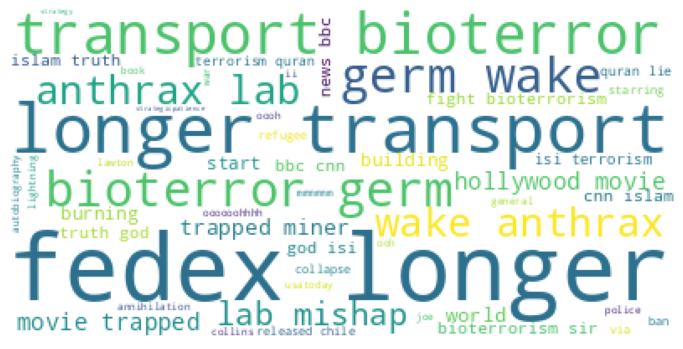

In [26]:
word_cloud(fp, max_words=50)


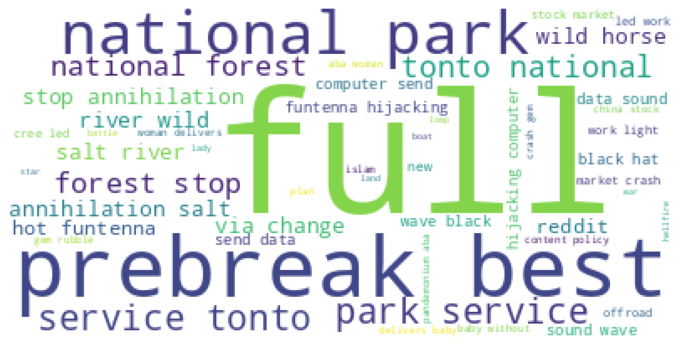

In [27]:
word_cloud(fn, max_words=50)


In [28]:
import ast
fp_ast = []
for text in fp:
    fp_ast.extend(ast.literal_eval(text))
word_cloud(fp_ast, max_words=50)


SyntaxError: invalid syntax (<unknown>, line 1)

In [29]:
import ast
fn_ast = []
for text in fn:
    fn_ast.extend(ast.literal_eval(text))
word_cloud(fn_ast, max_words=50)


SyntaxError: unexpected EOF while parsing (<unknown>, line 1)